<a href="https://colab.research.google.com/github/ram130849/object_detection_using_retinanet/blob/main/Object_Detection_using_RetinaNet_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U opencv-python
!pip install -q -U albumentations
!pip install -q -U bounding-box

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp -R /content/gdrive/MyDrive/Pets/pets_images.tar.gz /content/

In [4]:
!tar xf /content/gdrive/MyDrive/Pets/pets_images.tar.gz
!tar xf /content/gdrive/MyDrive/Pets/pets_annotations.tar.gz

In [5]:
import sys
import os
import re
import cv2
import torch
import torchvision
import time
import math
import torch.nn as nn
import numpy as np
import pandas as pd
import albumentations as A
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import model_selection, preprocessing
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.ops import misc
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from albumentations.pytorch import ToTensorV2
from PIL import Image
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow

In [6]:
img_desc = Path("/content/images")
ims = list(img_desc.iterdir())
ims = [str(pth) for pth in ims]

img_pths = []
print("[INFO] Gatering images")
# Accept only the image files
for im in tqdm(ims):
    if im.split(os.path.sep)[-1].split(".")[-1] == "jpg":
        img_pths.append(im)

img_pths[:5], len(img_pths)

[INFO] Gatering images


  0%|          | 0/7393 [00:00<?, ?it/s]

(['/content/images/samoyed_12.jpg',
  '/content/images/leonberger_150.jpg',
  '/content/images/Ragdoll_20.jpg',
  '/content/images/Bombay_53.jpg',
  '/content/images/japanese_chin_60.jpg'],
 7390)

In [7]:
# Clear out the images that open_cv cannot open
for pth in tqdm(img_pths):
    try: _ = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
    except:
        img_pths.remove(pth)
        print(f"[INFO] Corrupted image: {pth}")

  0%|          | 0/7390 [00:00<?, ?it/s]

[INFO] Corrupted image: /content/images/Egyptian_Mau_145.jpg
[INFO] Corrupted image: /content/images/Abyssinian_34.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_191.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_177.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_139.jpg
[INFO] Corrupted image: /content/images/Egyptian_Mau_167.jpg


In [8]:
annot_dir = Path("/content/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]

ann_pths = []
print("[INFO] Creating the paths to the annotations ...")
for a in tqdm(annots):
    for i in img_pths:
        # Check if the annotation file for an image is in 
        # our verified img_pths or not
        i_pth = i.split(os.path.sep)[-1].split(".")[0]
        a_pth = a.split(os.path.sep)[-1].split(".")[0]
        if(i_pth == a_pth): 
            ann_pths.append(a)
print("Annotation files found : ", len(ann_pths))

[INFO] Creating the paths to the annotations ...


  0%|          | 0/3686 [00:00<?, ?it/s]

Annotation files found :  3686


In [9]:
def xml_to_csv(pths:list) -> pd.DataFrame:
    """Extracts the filenames and the bboxes from the xml_list"""
    print("[INFO] Gathering the filenames and bboxes")
    xml_list = []
    for xml_file in tqdm(pths):
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc/root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except: pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [10]:
df = xml_to_csv(ann_pths)

[INFO] Gathering the filenames and bboxes


  0%|          | 0/3686 [00:00<?, ?it/s]

In [11]:
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

# 1. Extract the label
df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]
# 2. Convert the classes to integers
df["target"] = preprocessing.LabelEncoder().fit_transform(df["class"].values) + 1
# 3. Shuffle the dataFrame
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/images/american_pit_bull_terrier_162.jpg,134.0,32.0,232.0,162.0,american_pit_bull_terrier,3
1,/content/images/chihuahua_138.jpg,96.0,44.0,176.0,130.0,chihuahua,11
2,/content/images/Bengal_127.jpg,115.0,14.0,204.0,122.0,bengal,6
3,/content/images/pug_141.jpg,81.0,21.0,221.0,130.0,pug,26
4,/content/images/keeshond_139.jpg,181.0,46.0,333.0,245.0,keeshond,19


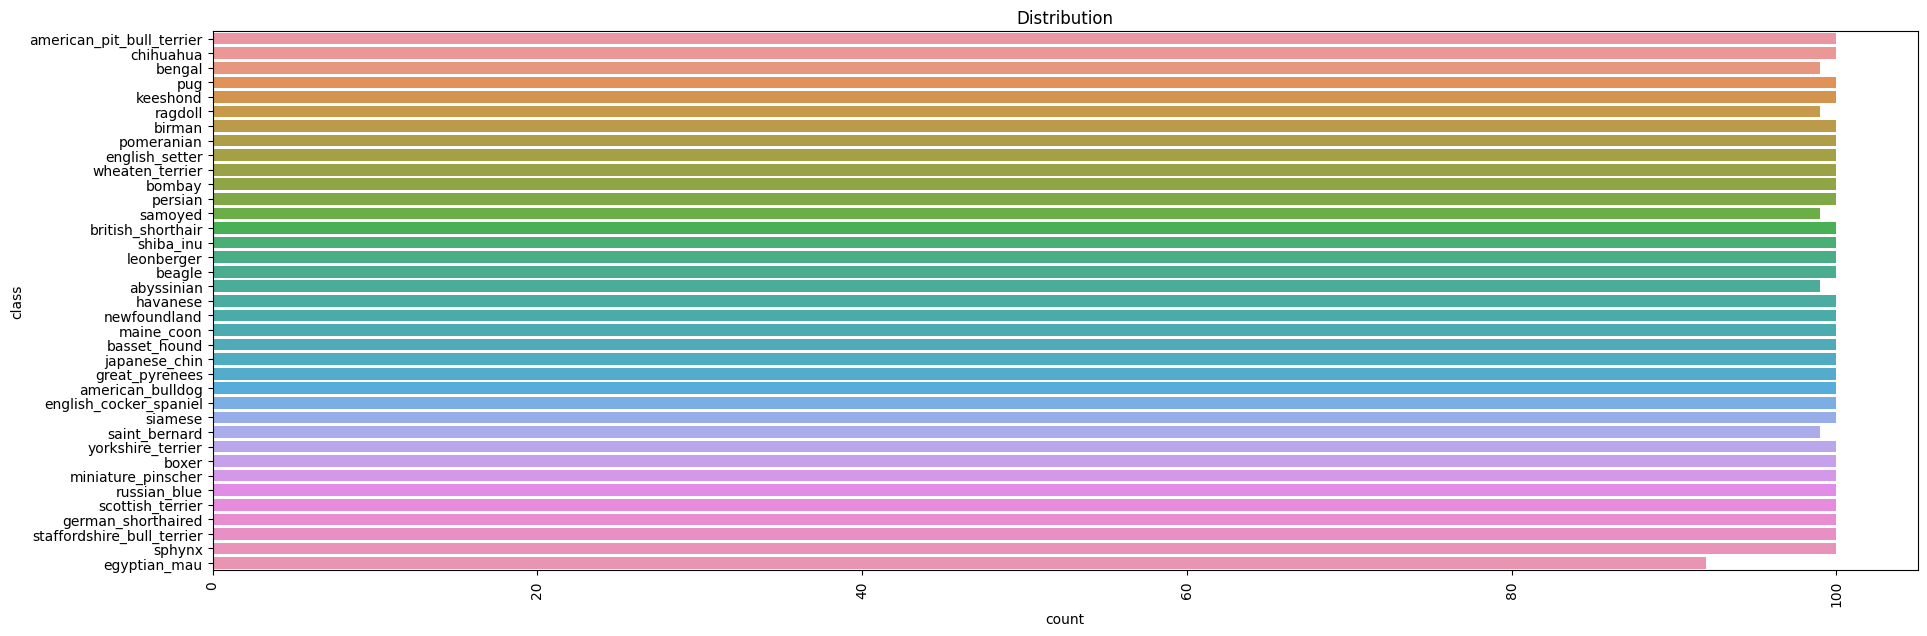

In [12]:
_, ax = plt.subplots(1, 1, figsize=(22, 7))
sns.countplot(y=df["class"], ax=ax)
ax.set_title("Distribution")
plt.xticks(rotation=90)
plt.show()

In [13]:
def view_rndm_sample():
    n = np.random.randint(0, len(df))
    im = cv2.cvtColor(cv2.imread(df.filename[n]), cv2.COLOR_BGR2RGB)
    bb.add(im, df["xmin"][n], df["ymin"][n], df["xmax"][n], df["ymax"][n],
           df["class"][n], color="green")
    cv2_imshow(im)

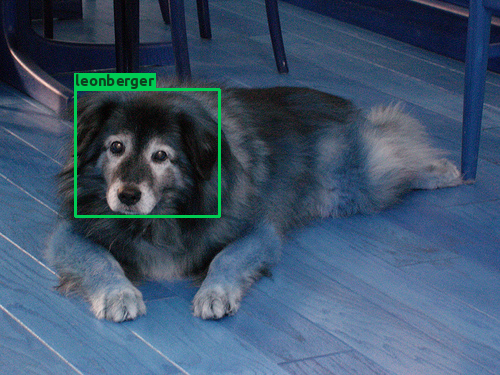

In [14]:
view_rndm_sample()

In [15]:
df.to_csv("/content/gdrive/MyDrive/pet_img_files_annots.csv", index=False)

In [16]:
df = pd.read_csv("/content/gdrive/MyDrive/pet_img_files_annots.csv")
df.head()

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/images/american_pit_bull_terrier_162.jpg,134.0,32.0,232.0,162.0,american_pit_bull_terrier,3
1,/content/images/chihuahua_138.jpg,96.0,44.0,176.0,130.0,chihuahua,11
2,/content/images/Bengal_127.jpg,115.0,14.0,204.0,122.0,bengal,6
3,/content/images/pug_141.jpg,81.0,21.0,221.0,130.0,pug,26
4,/content/images/keeshond_139.jpg,181.0,46.0,333.0,245.0,keeshond,19


In [17]:
# Dictionary mapping from target to class
class_dict = {t:c for t, c in list(zip(list(df.target.unique()), list(df["class"].unique())))}

In [18]:
class_dict

{3: 'american_pit_bull_terrier',
 11: 'chihuahua',
 6: 'bengal',
 26: 'pug',
 19: 'keeshond',
 27: 'ragdoll',
 7: 'birman',
 25: 'pomeranian',
 14: 'english_setter',
 36: 'wheaten_terrier',
 8: 'bombay',
 24: 'persian',
 30: 'samoyed',
 10: 'british_shorthair',
 32: 'shiba_inu',
 20: 'leonberger',
 5: 'beagle',
 1: 'abyssinian',
 17: 'havanese',
 23: 'newfoundland',
 21: 'maine_coon',
 4: 'basset_hound',
 18: 'japanese_chin',
 16: 'great_pyrenees',
 2: 'american_bulldog',
 13: 'english_cocker_spaniel',
 33: 'siamese',
 29: 'saint_bernard',
 37: 'yorkshire_terrier',
 9: 'boxer',
 22: 'miniature_pinscher',
 28: 'russian_blue',
 31: 'scottish_terrier',
 15: 'german_shorthaired',
 35: 'staffordshire_bull_terrier',
 34: 'sphynx',
 12: 'egyptian_mau'}

In [19]:
train, test = model_selection.train_test_split(df, stratify=df.target, random_state=42, shuffle=True, test_size=0.3)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print("[INFO] No. of training examples: ", len(train))
print("[INFO] No. of validation examples: ", len(test))

[INFO] No. of training examples:  2580
[INFO] No. of validation examples:  1107


In [20]:
train.head(2)

,filename,xmin,ymin,xmax,ymax,class,target
0,/content/images/saint_bernard_148.jpg,83.0,34.0,391.0,309.0,saint_bernard,29
1,/content/images/boxer_157.jpg,33.0,27.0,244.0,281.0,boxer,9


In [21]:
def get_transforms(phase):
    # Train transforms
    trn_tfms = A.Compose([
        A.ToGray(p=0.2),
        A.HorizontalFlip(),
        A.Rotate(limit=60),
        A.CLAHE(),
        A.Sharpen(),
        A.Perspective(),
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ], p=1., bbox_params=A.BboxParams(format="pascal_voc"))

    # Validation transforms
    val_tfms = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),   
    ], p=1., bbox_params=A.BboxParams(format="pascal_voc"))
    return trn_tfms if(phase=='train') else val_tfms

In [22]:
class ParseData(Dataset):
    def __init__(self, df, trn):
        self.df = df
        self.transforms = get_transforms(trn)
                
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        # read in the image
        im = cv2.cvtColor(cv2.imread(self.df.filename[idx]), cv2.COLOR_BGR2RGB)

        # normalize the image to be between 0 and 1

        # im = im / 255.0
        # parse the bboxes
        bboxes = []
        bboxes.append(self.df.xmin[idx])
        bboxes.append(self.df.ymin[idx])
        bboxes.append(self.df.xmax[idx])
        bboxes.append(self.df.ymax[idx])

        # apply transfromations
        bboxes.append(self.df["target"][idx])
        trn_data = self.transforms(image=im, bboxes=[bboxes])
        try: 
            im, bboxes = trn_data["image"], trn_data["bboxes"][0][:4]
        except : 
            print(f"[INFO] Something wrong ... {self.df.filename[idx]}")
            sys.exit(0)

        # convert everything to torch.tensor
        image_id = torch.tensor([idx])
        trgt = torch.tensor((self.df["target"][idx], ), dtype=torch.int64)
        bboxes = torch.as_tensor([bboxes], dtype=torch.float32)
        area = torch.tensor(((bboxes[0][3] - bboxes[0][1]) * (bboxes[0][2] - bboxes[0][0]),), dtype=torch.float32)
        iscrowd = torch.zeros((1, ), dtype=torch.int64)
        # Create target dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = trgt
        # target["image_id"] = image_id
        # target["area"] = area
        # target["iscrowd"] = iscrowd

        return im, target

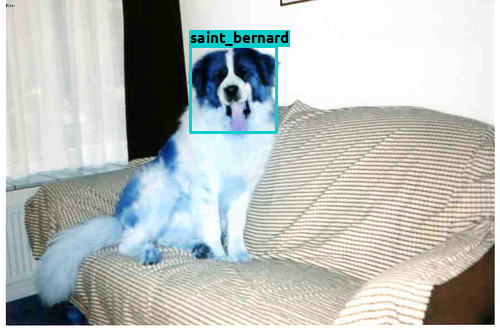

In [23]:
# Sanity Check

# Display a random sample from the dataset
n = np.random.randint(0, len(df))

tmp = ParseData(df, trn=True)
i,t = tmp.__getitem__(n)

trgt = int(t["labels"][0].numpy())

t_xmin = t["boxes"][0][0].numpy()
t_ymin = t["boxes"][0][1].numpy()
t_xmax = t["boxes"][0][2].numpy()
t_ymax = t["boxes"][0][3].numpy()

# Print Info
# print("image dims: ", i.size())
# print("bbox coordinates: ", t_xmin, t_ymin, t_xmax, t_ymax)
# print("bbox area: ", t["area"][0].numpy())
# print("image_id: ", t["image_id"][0].numpy())
# print("label: ", t["labels"][0].numpy())
# print("target_dict: ", t)

# De-Normalize the image?
im = i.permute(1, 2, 0).numpy()*255


# Add the bounding box
bb.add(im, t_xmin, t_ymin, t_xmax, t_ymax, class_dict[trgt], color="teal")
# display the image
cv2_imshow(im)
plt.show()

In [24]:
def collate_fn(batch): return tuple(zip(*batch))

In [25]:
train_loader = DataLoader(ParseData(train, True), batch_size=2, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(ParseData(test, False), batch_size=2, collate_fn=collate_fn)

In [26]:
no_classes = len(df.target.unique()) + 1
no_classes

38

In [27]:
# Finetuning Torchvision Retina net 

In [28]:
torchvision.__version__

'0.15.1+cu118'

In [29]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = no_classes, weights = None, weights_backbone='ResNet50_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 332MB/s]


In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 30
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [31]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Define the parameters that need to be optimized separately
# in this case, we freeze the early layers in the backbone and
# only optimize the later layers and the classification and regression heads
params = [
    {'params': retina.head.classification_head.parameters(), 'lr': 0.001},
    {'params': retina.head.regression_head.parameters(), 'lr': 0.001},
    {'params': retina.backbone.fpn.parameters(), 'lr': 0.001},
    {'params': retina.backbone.body.layer3.parameters(), 'lr': 0.0001},
    {'params': retina.backbone.body.layer4.parameters(), 'lr': 0.0001}
]

# parameters
# params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [33]:
# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    nan_count = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 
        losses = sum(loss for loss in loss_dict.values())

        i += 1

    
        optimizer.zero_grad()
        losses.backward()

        torch.nn.utils.clip_grad_norm_(retina.parameters(), max_norm=0.1)

        optimizer.step()
        scheduler.step()
        epoch_loss += losses 
  
    print(epoch_loss, f'time: {time.time() - start}')
    print(f'nan_cnt: {nan_count}')
    print(f'total: {i}')

tensor(2553.4971, device='cuda:0', grad_fn=<AddBackward0>) time: 834.9581141471863
nan_cnt: 0
total: 1290
tensor(2553.9211, device='cuda:0', grad_fn=<AddBackward0>) time: 835.1751515865326
nan_cnt: 0
total: 1290
tensor(2553.4592, device='cuda:0', grad_fn=<AddBackward0>) time: 833.8513391017914
nan_cnt: 0
total: 1290
tensor(2553.8508, device='cuda:0', grad_fn=<AddBackward0>) time: 835.1094462871552
nan_cnt: 0
total: 1290
tensor(2553.8789, device='cuda:0', grad_fn=<AddBackward0>) time: 835.8769648075104
nan_cnt: 0
total: 1290
tensor(2554.7185, device='cuda:0', grad_fn=<AddBackward0>) time: 838.8507916927338
nan_cnt: 0
total: 1290
tensor(2554.6812, device='cuda:0', grad_fn=<AddBackward0>) time: 838.5723147392273
nan_cnt: 0
total: 1290
tensor(2553.9355, device='cuda:0', grad_fn=<AddBackward0>) time: 835.8818602561951
nan_cnt: 0
total: 1290
tensor(2552.2786, device='cuda:0', grad_fn=<AddBackward0>) time: 830.3992459774017
nan_cnt: 0
total: 1290


KeyboardInterrupt: ignored

In [ ]:
# Our own implementaion of Retina net

In [ ]:
backbone = torchvision.models.quantization.mobilenet_v3_large(pretrained=True,width_mult=1.0,  reduced_tail=False, dilated=False)

In [ ]:
class ClassificationHead(nn.Module):
      def __init__(self,in_channels,no_anchors,no_classes,prior_prob=0.01,norm_layer=None):
          super().__init__()
          conv = []
          for i in range(4):
              conv.append(misc.Conv2dNormActivation(in_channels,in_channels,norm_layer=norm_layer))
          self.conv = nn.Sequential(*conv)
          for layers in self.conv.modules():
              torch.nn.init.xavier_uniform(layers.weight,std=0.01)
              if(layers.bias is not None):
                  torch.nn.init.constant_(layers.bias,0)
          self.cls_logits = nn.Conv2d(in_channels,no_anchors*no_classes,kernel_size=3,stride=1,padding=1)
          torch.nn.init.xavier_normal(self.cls_logits.weight,std=0.01)
          torch.nn.init.constant_(self.cls_logits.bias,-math.log((1-prior_prob)/prior_prob))
          self.BETWEEN_THRESHOLDS = -2
          self.no_anchors = no_anchors
          self.no_classes = no_classes

      def compute_loss(self,target,output,matched_idx):
          loss = []
          cls_logits = output['cls_logits']

      def forward(self,x):
          all_output = []
          for features in x:
              out = self.conv(features)
              out = self.cls_logits(out)
              N,_,H,W = out.shape
              out = out.view(N,-1,self.no_classes,H,W)
              out = out.permute(0,3,4,1,2)
              out = out.reshape(N,-1,self.no_classes)
              all_output.append(out)
          return torch.cat(all_output,dim=1)

In [ ]:
class RegressionHead(nn.Module):
      def __init__(self,in_channels,no_anchors,norm_layer=None):
          super().__init__()
          conv = []
          for i in range(4):
              conv.append(misc.Conv2dNormActivation(in_channels,in_channels,norm_layer=norm_layer))
          self.conv = nn.Sequential(*conv)
          for layers in self.conv.modules():
              torch.nn.init.xavier_uniform(layers.weight,std=0.01)
              if(layers.bias is not None):
                  torch.nn.init.zeros_(layers.bias)
          self.bbox_reg = nn.Conv2d(in_channels, no_anchors * 4, kernel_size=3, stride=1, padding=1)
          torch.nn.init.normal_(self.bbox_reg.weight, std=0.01)
          torch.nn.init.zeros_(self.bbox_reg.bias)
          self.box_coder = None
          self.loss_type = 'l1'
      def compute_loss(self,targets,output,anchors,matched_idx):
          losses = []
          bbox_regression = output['bbox_regression']
          
          return sum(losses)/max(1,len(targets))

      def forward(self,x):
          all_output = []
          for features in x:
              out = self.conv(features)
              out = self.bbox_reg(out)
              N,_,H,W = out.shape
              out = out.view(N,-1,4,H,W)
              out = out.permute(0,3,4,1,2)
              out = out.reshape(N,-1,4)
              all_output.append(out)
          return torch.cat(all_output,dim=1)

In [ ]:
class RetinaNetModel(nn.Module):
    def __init__(self,in_channels,no_anchors,no_classes,norm_layer=None):
        super().__init__()
        self.classification_net = ClassificationHead(in_channels,no_anchors,no_classes,norm_layer = norm_layer)
        self.regression_net = RegressionHead(in_channels,no_anchors,norm_layer=norm_layer)

    def compute_loss(self,targets,outputs,anchors,matched_idx):
        return {
            'classification': self.classification_net.compute_loss(targets,outputs,matched_idx),
            'bbox_regression': self.regression_net.compute_loss(targets,outputs,anchors,matched_idx)
        }

    def forward(self,x):
        return {
            'cls_logits': self.classification_net(x),
            'bbox_regression': self.regression_net(x)
        }

In [ ]:
def default_anchorgen():
    anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [32, 64, 128, 256, 512])
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    return anchor_generator

In [ ]:
class RetinaNet(nn.Module):
      def __init__(self,backbone,no_classes,min_size=800,max_size=1333,mean=None,std=None,
                   anchor_generator=None,proposal_matcher=None,score_thresh=0.05,nms_thresh=0.5,detections_per_img=300,
                   fg_iou_thresh=0.5,bg_iou_thresh=0.4,topk_candidates=1000,**kwargs):
          super().__init__()
          self.backbone = backbone
          if anchor_generator is None:
            anchor_generator = default_anchorgen()
          self.anchor_generator = anchor_generator
          if head is None:
            head = RetinaNetModel(backbone.out_channels, anchor_generator.num_anchors_per_location()[0], no_classes)
          self.head = head
          if(proposal_matcher is None):
              proposal_matcher = None
          self.proposal_matcher = proposal_matcher
          if mean is None:
            mean = [0.485, 0.456, 0.406]
          if std is None:
              std = [0.229, 0.224, 0.225]
          self.transform = GeneralizedRCNNTransform(min_size, max_size, mean, std, **kwargs)
          self.score_thresh = score_thresh
          self.nms_thresh = nms_thresh
          self.detections_per_img = detections_per_img
          self.topk_candidates = topk_candidates
      # @torch.jit.unused
      # def eager_outputs(self, losses, detections):
      #     if self.training:
      #         return losses
      #     return detections
      def compute_loss(self, targets, outputs, anchors):
          

In [ ]:
# class MobileNetV3(nn.Module):
#     def __init__(self,inverted_residual_setting,last_channel: int,num_classes,block=None,norm_layer=None,dropout = 0.2):
#         super().__init__()


In [ ]:
# anchor_generator = AnchorGenerator(
#       sizes=((32, 64, 128, 256, 512),),
#       aspect_ratios=((0.5, 1.0, 2.0),)
#   )